In [28]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [66]:
import warnings

warnings.filterwarnings('ignore')

In [29]:
df = pd.read_csv('../week3/data.csv')

# Data preparation

In [30]:
from lib.data_preparation import sanitize_string_columns_and_values

columns = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
           'highway MPG', 'city mpg', 'MSRP']
df = df[columns]
sanitize_string_columns_and_values(df)
df.fillna(0, inplace=True)
df['above_average'] = df['msrp'] > df.msrp.mean()

In [31]:
from sklearn.model_selection import train_test_split

seed = 1

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_valid = train_test_split(df_train_full, test_size=0.25, random_state=seed)

y_train = df_train.above_average.values
y_valid = df_valid.above_average.values
y_test = df_test.above_average.values

df_train.drop(columns=['above_average', 'msrp'], inplace=True)
df_valid.drop(columns=['above_average', 'msrp'], inplace=True)
df_test.drop(columns=['above_average', 'msrp'], inplace=True)

# Question 1: ROC AUC feature importance

In [32]:
numerical_columns = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical_columns = ['make', 'model', 'transmission_type', 'vehicle_style']

In [35]:
from sklearn.metrics import roc_auc_score

for numerical_column in numerical_columns:
    auc = roc_auc_score(y_train, df_train[numerical_column].values)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[numerical_column].values)
    print(f'{numerical_column}: {round(auc, 3)}')

year: 0.688
engine_hp: 0.917
engine_cylinders: 0.766
highway_mpg: 0.633
city_mpg: 0.673


In [36]:
print('q1: engine_hp')

q1: engine_hp


# Question 2: Training the model

In [43]:
from sklearn.feature_extraction import DictVectorizer


def get_encoder(df: pd.DataFrame) -> DictVectorizer:
    copy = df.copy()
    copy = copy.to_dict(orient='records')
    encoder = DictVectorizer(sparse=False)
    encoder.fit(copy)
    return encoder


def get_input(df: pd.DataFrame, encoder: DictVectorizer):
    copy = df.copy()
    copy = copy.to_dict(orient='records')
    x = encoder.transform(copy)
    return x

In [44]:
from sklearn.linear_model import LogisticRegression


def train(df, y) -> (LogisticRegression, DictVectorizer):
    encoder = get_encoder(df)
    x = get_input(df, encoder)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(x, y)
    return model, encoder


def predict(df: pd.DataFrame, model: LogisticRegression, encoder: DictVectorizer):
    x = get_input(df, encoder)
    return model.predict_proba(x)[:, 1]

In [48]:
model, encoder = train(df_train, y_train)
y_pred = predict(df_valid, model, encoder)
print('q2:', round(roc_auc_score(y_valid, y_pred), 4))

q2: 0.9798


# Question 3: Precision and Recall

In [77]:
from sklearn.metrics import precision_score, recall_score

precisions = []
recalls = []
my_precisions = []
my_recalls = []
thresholds = np.arange(0, 1, 0.01)

for threshold in thresholds:
    y_pred_flag = y_pred >= threshold

    true_positive = ((y_valid == True) & (y_pred_flag == True)).sum()
    true_negative = ((y_valid == False) & (y_pred_flag == False)).sum()
    false_positive = ((y_valid == False) & (y_pred_flag == True)).sum()
    false_negative = ((y_valid == True) & (y_pred_flag == False)).sum()

    my_precision = true_positive / (true_positive + false_positive)
    my_recall = true_positive / (true_positive + false_negative)
    my_precisions.append(my_precision)
    my_recalls.append(my_recall)

    precision = precision_score(y_valid, y_pred_flag)
    recall = recall_score(y_valid, y_pred_flag)
    precisions.append(precision)
    recalls.append(recall)

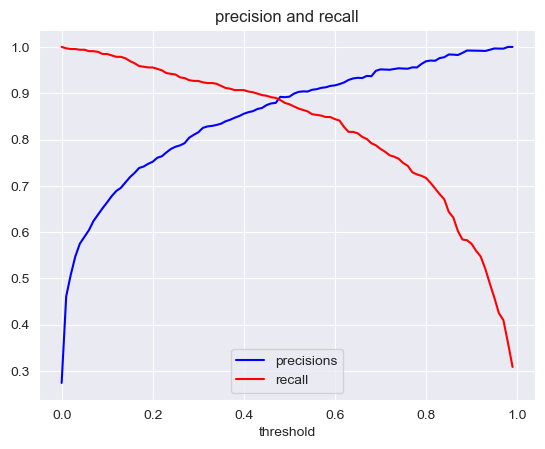

In [78]:
# plot both lines
plt.plot(thresholds, precisions, color='blue', label='precisions')
plt.plot(thresholds, recalls, color='red', label='recall')

# add legend and labels
plt.legend()
plt.xlabel('threshold')
plt.title('precision and recall')
plt.legend()

# show the plot
plt.show()

In [86]:
precision_vs_recall = pd.DataFrame({
    'threshold': thresholds,
    'precisions': precisions,
    'recall': recalls
})

precision_vs_recall[precision_vs_recall['precisions'] > precision_vs_recall['recall']].head(1)

,threshold,precisions,recall
48,0.48,0.892142,0.885321


In [85]:
print('q3: 0.48')

q3: 0.48


# Question 4: F1 score